# NEAT Algorithm-based Trading Strategy Development

This notebook demonstrates how to use the NEAT Trader package to develop, train, and optimize automated trading strategies using NeuroEvolution of Augmenting Topologies (NEAT).

## Overview

The NEAT algorithm evolves neural networks to create trading strategies that can:
- Analyze multiple technical indicators simultaneously
- Make buy/sell decisions based on complex market patterns
- Adapt and evolve to changing market conditions
- Optimize for multiple objectives (returns, risk, trade frequency)

## Table of Contents
1. [Setup and Configuration](#setup)
2. [Data Exploration](#data)
3. [NEAT Configuration](#neat-config)
4. [Strategy Development](#strategy)
5. [Performance Analysis](#analysis)
6. [Visualization](#visualization)
7. [Strategy Optimization](#optimization)


<a id="setup"></a>
## 1. Setup and Configuration

First, let's import the necessary packages and configure our environment.


In [3]:
# Core imports
import neat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# NEAT Trader package imports
from neat_trader import (
    NeatTrader,
    Evaluator,
    DataHandler,
    CryptoDataHandler,
    multi_objective_fitness_function_2,
    get_config,
    NODE_NAMES
)
from neat_trader.algorithm.fitness_fn import (
    multi_objective_fitness_function_1,
    outperform_benchmark,
    gpt_fitness_fn,
    crypto_fitness_fn
)
from neat_trader.exceptions import NEATTraderError, DataError, EvaluationError

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All packages imported successfully!")
print(f"📊 Available node names: {list(NODE_NAMES.values())}")


✅ All packages imported successfully!
📊 Available node names: ['long_position', 'short_position', 'sma5', 'sma10', 'slowk', 'slowd', 'macdhist_diff', 'cci', 'willr', 'rsi', 'adosc', 'buy', 'sell', 'volume']


<a id="data"></a>
## 2. Data Exploration

Let's explore the available market data and understand what we're working with.


In [4]:
# Initialize data handlers
stock_data_handler = DataHandler('data/mydatabase.db')
crypto_data_handler = CryptoDataHandler('data/binance.db')

print("📈 Data handlers initialized")
print(f"📁 Stock database: {stock_data_handler.db_path}")
print(f"📁 Crypto database: {crypto_data_handler.db_path}")


📈 Data handlers initialized
📁 Stock database: data/mydatabase.db
📁 Crypto database: data/binance.db


In [5]:
# Get sample data to understand the structure
try:
    sample_stock_data = stock_data_handler.get_random_data(data_length=100)
    print("✅ Stock data loaded successfully")
    print(f"📊 Stock data shape: {sample_stock_data.shape}")
    print(f"📅 Date range: {sample_stock_data.index[0]} to {sample_stock_data.index[-1]}")
    print("\n📋 Stock data columns:")
    for col in sample_stock_data.columns:
        print(f"  - {col}")
    
except DataError as e:
    print(f"❌ Stock data error: {e}")
    sample_stock_data = None

# Try crypto data
try:
    sample_crypto_data = crypto_data_handler.get_random_data(data_length=100)
    print("\n✅ Crypto data loaded successfully")
    print(f"📊 Crypto data shape: {sample_crypto_data.shape}")
    print(f"📅 Date range: {sample_crypto_data.index[0]} to {sample_crypto_data.index[-1]}")
    
except DataError as e:
    print(f"❌ Crypto data error: {e}")
    sample_crypto_data = None


✅ Stock data loaded successfully
📊 Stock data shape: (100, 7)
📅 Date range: 2011-03-16 00:00:00 to 2011-08-05 00:00:00

📋 Stock data columns:
  - Datetime
  - Ticker
  - Open
  - High
  - Low
  - Close
  - Volume

✅ Crypto data loaded successfully
📊 Crypto data shape: (100, 5)
📅 Date range: 2024-04-14 12:45:00 to 2024-04-15 13:30:00


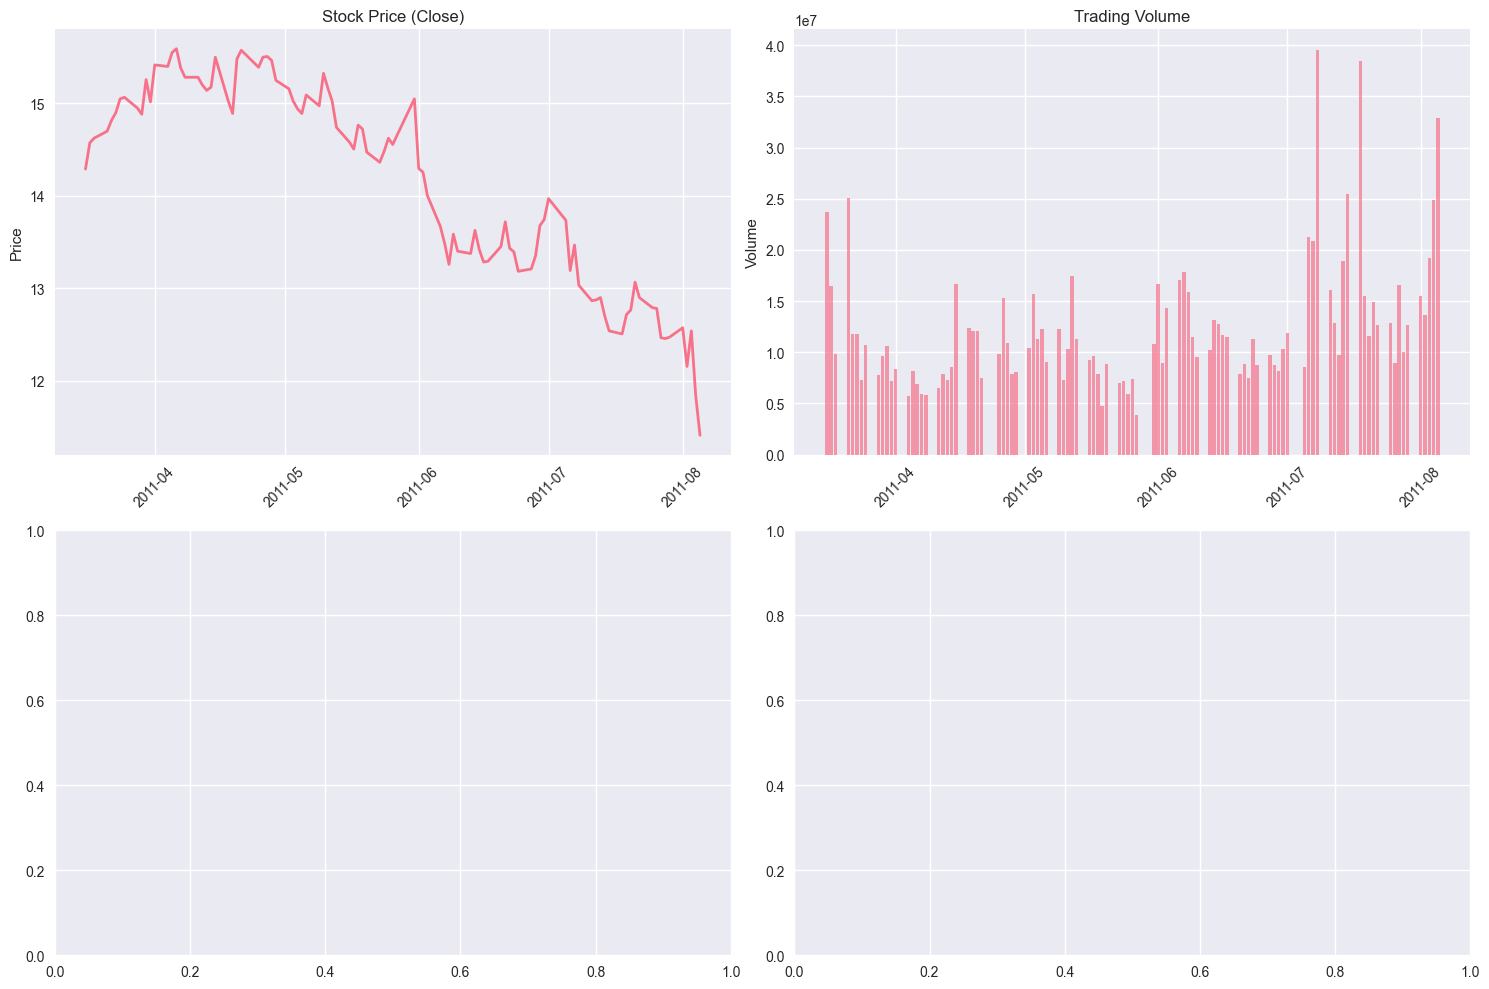


📊 Sample data statistics:
             Open        High         Low       Close        Volume
count  100.000000  100.000000  100.000000  100.000000  1.000000e+02
mean    14.167474   14.301774   13.989544   14.130162  1.233153e+07
std      1.041337    1.027751    1.062292    1.065036  6.285271e+06
min     11.981286   12.073192   11.296164   11.413136  3.823400e+06
25%     13.280509   13.441345   13.153092   13.278419  8.345475e+06
50%     14.508718   14.630448   14.320725   14.475296  1.072650e+07
75%     15.076810   15.216163   14.916386   15.047565  1.449200e+07
max     15.688742   15.738706   15.530524   15.588816  3.956670e+07


In [6]:
# Visualize sample data if available
if sample_stock_data is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Price chart
    axes[0, 0].plot(sample_stock_data.index, sample_stock_data['Close'], linewidth=2)
    axes[0, 0].set_title('Stock Price (Close)')
    axes[0, 0].set_ylabel('Price')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Volume chart
    axes[0, 1].bar(sample_stock_data.index, sample_stock_data['Volume'], alpha=0.7)
    axes[0, 1].set_title('Trading Volume')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Technical indicators
    if 'rsi' in sample_stock_data.columns:
        axes[1, 0].plot(sample_stock_data.index, sample_stock_data['rsi'], color='orange')
        axes[1, 0].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
        axes[1, 0].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
        axes[1, 0].set_title('RSI Indicator')
        axes[1, 0].set_ylabel('RSI')
        axes[1, 0].legend()
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    if 'macdhist_diff' in sample_stock_data.columns:
        axes[1, 1].bar(sample_stock_data.index, sample_stock_data['macdhist_diff'], alpha=0.7)
        axes[1, 1].set_title('MACD Histogram')
        axes[1, 1].set_ylabel('MACD Hist')
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Sample data statistics:")
    print(sample_stock_data.describe())


<a id="neat-config"></a>
## 3. NEAT Configuration

Now let's configure the NEAT algorithm parameters and explore available fitness functions.


In [12]:
# Load NEAT configuration
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    'model/config-feedforward'
)

print("✅ NEAT configuration loaded")
print(f"🧬 Population size: {config.pop_size}")
print(f"🎯 Fitness criterion: {config.fitness_criterion}")
print(f"🔄 Activation function: {config.genome_config.activation_default}")


✅ NEAT configuration loaded
🧬 Population size: 256
🎯 Fitness criterion: max
🔄 Activation function: relu


In [16]:
# Explore available fitness functions
fitness_functions = {
    'Multi-Objective 2': multi_objective_fitness_function_2,
    'Multi-Objective 1': multi_objective_fitness_function_1,
    'Outperform Benchmark': outperform_benchmark,
    'GPT Fitness': gpt_fitness_fn,
    'Crypto Fitness': crypto_fitness_fn
}

print("🎯 Available fitness functions:")
newline = "\n"
for name, func in fitness_functions.items():
    print(f"  - {name}: {func.__doc__.split(newline)[1] if func.__doc__ else 'No description'}")


# Get configuration details
config_details = get_config()
print("\n⚙️ Configuration details:")
print(f"  💰 Default cash: ${config_details['trading']['cash']:,}")
print(f"  📊 Commission: {config_details['trading']['commission']*100:.2f}%")
print(f"  📈 Trading period: {config_details['trading']['period_length']} days")
print(f"  🧬 Generations: {config_details['trading']['total_generation']}")


🎯 Available fitness functions:
  - Multi-Objective 2:     Advanced multi-objective fitness function with continuous scoring.
  - Multi-Objective 1:     Multi-objective fitness function with discrete scoring.
  - Outperform Benchmark:     Fitness function focused on outperforming benchmark (buy & hold).
  - GPT Fitness:     Advanced fitness function using Sharpe ratio and trade frequency optimization.
  - Crypto Fitness:     Fitness function optimized for cryptocurrency trading.

⚙️ Configuration details:
  💰 Default cash: $1,000,000
  📊 Commission: 0.20%
  📈 Trading period: 90 days
  🧬 Generations: 200


<a id="strategy"></a>
## 4. Strategy Development

Let's develop a trading strategy by training the NEAT algorithm. We'll start with a small-scale evolution for demonstration.


In [17]:
# Initialize evaluator with multi-objective fitness function
evaluator = Evaluator(
    data_handler=stock_data_handler,
    fitness_fn=multi_objective_fitness_function_2
)

# Initialize NEAT trader
trader = NeatTrader(config, evaluator)

print("🚀 NEAT Trader initialized successfully!")
print(f"📁 Checkpoint directory: {trader.checkpoint_path}")
print(f"🧬 Population size: {len(trader.population.population)}")


🚀 NEAT Trader initialized successfully!
📁 Checkpoint directory: checkpoint/0912_2132/
🧬 Population size: 256


In [18]:
# Run a small-scale evolution for demonstration
print("🧬 Starting NEAT evolution...")
print("⏱️ This may take a few minutes...")

# For demonstration, we'll use a smaller number of generations
DEMO_GENERATIONS = 10
DEMO_PROCESSES = 4

start_time = datetime.now()

try:
    winner = trader.evolve(
        total_generation=DEMO_GENERATIONS,
        num_process=DEMO_PROCESSES
    )
    
    end_time = datetime.now()
    duration = end_time - start_time
    
    print(f"✅ Evolution completed successfully!")
    print(f"⏱️ Duration: {duration.total_seconds():.2f} seconds")
    print(f"🏆 Best fitness: {winner.fitness:.4f}")
    
except Exception as e:
    print(f"❌ Evolution failed: {e}")
    winner = None


🧬 Starting NEAT evolution...
⏱️ This may take a few minutes...

 ****** Running generation 0 ****** 

Population's average fitness: 0.04669 stdev: 0.00000
Best fitness: 0.04669 - size: (3, 36) - species 1 - id 1
Average adjusted fitness: -0.000
Mean genetic distance 1.093, standard deviation 0.231
Population of 256 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   256      0.0   -0.000     0
Total extinctions: 0
Generation time: 6.040 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.04669 stdev: 0.00000
Best fitness: 0.04669 - size: (3, 36) - species 1 - id 1
Average adjusted fitness: -0.000
Mean genetic distance 1.178, standard deviation 0.252
Population of 256 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   256      0.0   -0.000     1
Total extinctions: 0
Generation time: 3.294 sec (4.667 average)

 ****** Running gene

<a id="analysis"></a>
## 5. Performance Analysis

Let's analyze the performance of our evolved trading strategy.


In [19]:
if winner is not None:
    print("📊 Winner Genome Analysis:")
    print(f"🧬 Genome ID: {winner.key}")
    print(f"🎯 Fitness: {winner.fitness:.4f}")
    print(f"🔗 Number of connections: {len(winner.connections)}")
    print(f"🧠 Number of nodes: {len(winner.nodes)}")
    
    # Analyze connections
    enabled_connections = [conn for conn in winner.connections.values() if conn.enabled]
    print(f"✅ Enabled connections: {len(enabled_connections)}/{len(winner.connections)}")
    
    # Show network structure
    print("\n🔗 Network Structure:")
    for node_id, node in winner.nodes.items():
        node_name = NODE_NAMES.get(node_id, f'Node_{node_id}')
        print(f"  {node_id}: {node_name} (bias: {node.bias:.3f})")
    
    # Show enabled connections
    print("\n🔗 Enabled Connections:")
    for conn in enabled_connections[:10]:  # Show first 10 connections
        input_name = NODE_NAMES.get(conn.key[0], f'Node_{conn.key[0]}')
        output_name = NODE_NAMES.get(conn.key[1], f'Node_{conn.key[1]}')
        print(f"  {input_name} → {output_name} (weight: {conn.weight:.3f})")
    
    if len(enabled_connections) > 10:
        print(f"  ... and {len(enabled_connections) - 10} more connections")


📊 Winner Genome Analysis:
🧬 Genome ID: 1
🎯 Fitness: 0.1021
🔗 Number of connections: 36
🧠 Number of nodes: 3
✅ Enabled connections: 36/36

🔗 Network Structure:
  0: buy (bias: 0.129)
  1: sell (bias: -0.287)
  2: volume (bias: 0.683)

🔗 Enabled Connections:
  long_position → buy (weight: 0.009)
  long_position → sell (weight: 1.064)
  long_position → volume (weight: 0.786)
  short_position → buy (weight: -0.060)
  short_position → sell (weight: -1.958)
  short_position → volume (weight: -0.324)
  sma5 → buy (weight: 0.201)
  sma5 → sell (weight: 1.105)
  sma5 → volume (weight: -0.612)
  sma10 → buy (weight: -0.060)
  ... and 26 more connections


📋 Generating comprehensive report...

Best genome:
Key: 1
Fitness: 0.1021097941820416
Nodes:
	0 DefaultNodeGene(key=0, bias=0.1293471561455108, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.2871335337062487, response=1.0, activation=relu, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.682613649543071, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-11, 0), weight=-1.0762661495721357, enabled=True)
	DefaultConnectionGene(key=(-11, 1), weight=-0.4184217987449433, enabled=True)
	DefaultConnectionGene(key=(-11, 2), weight=0.38391939342185194, enabled=True)
	DefaultConnectionGene(key=(-10, 0), weight=-0.5473564375541842, enabled=True)
	DefaultConnectionGene(key=(-10, 1), weight=-0.9789092919202239, enabled=True)
	DefaultConnectionGene(key=(-10, 2), weight=-1.0788396589834501, enabled=True)
	DefaultConnectionGene(key=(-9, 0), weight=-0.5296355919258398, enabled=True)
	DefaultConnectionGene(key=(-9, 1), weight=0.

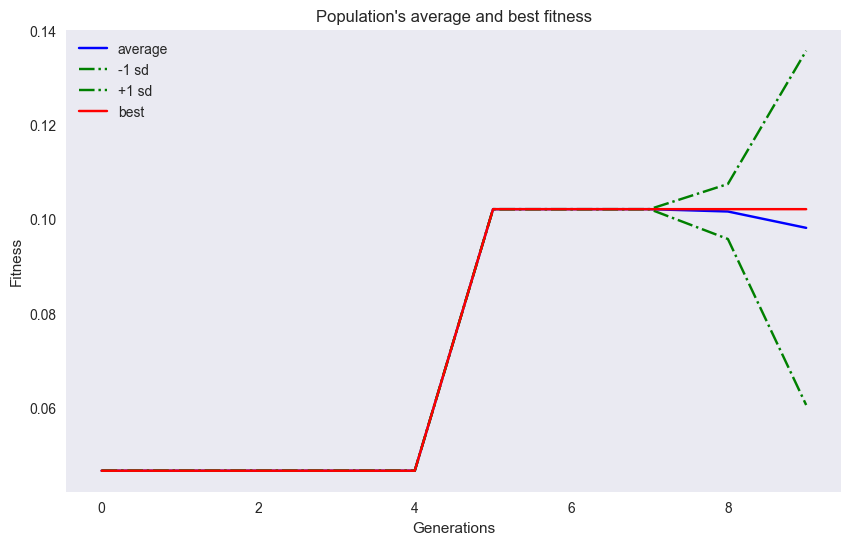

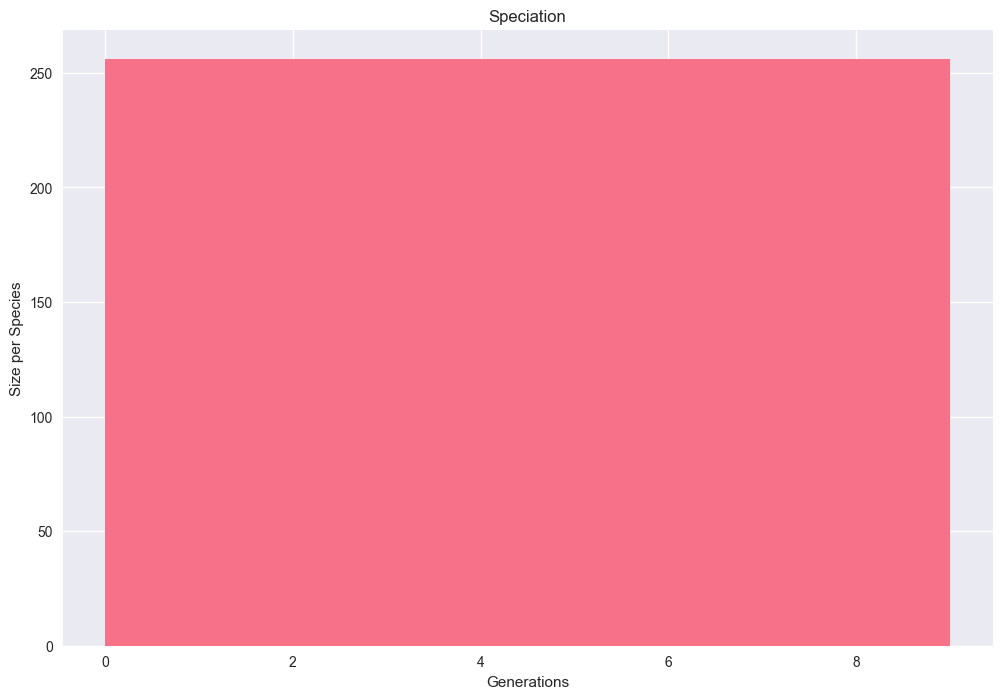

Report generated successfully in checkpoint/0912_2132/
✅ Report generated successfully!
📁 Check reports in: checkpoint/0912_2132//winner/


In [20]:
# Generate comprehensive report
if winner is not None:
    print("📋 Generating comprehensive report...")
    try:
        trader.generate_report()
        print("✅ Report generated successfully!")
        print(f"📁 Check reports in: {trader.checkpoint_path}/winner/")
    except Exception as e:
        print(f"❌ Report generation failed: {e}")


<a id="visualization"></a>
## 6. Visualization

Let's create visualizations to understand the evolution process and network structure.


📊 Creating evolution visualizations...


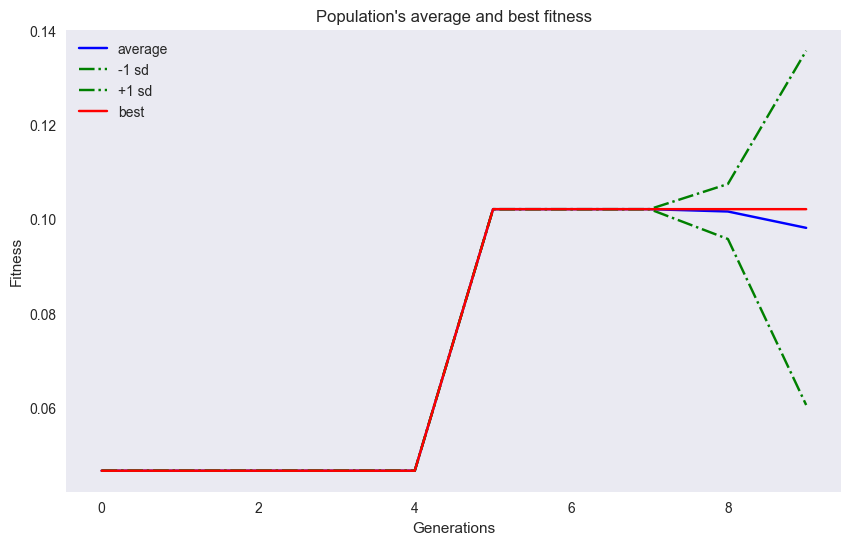

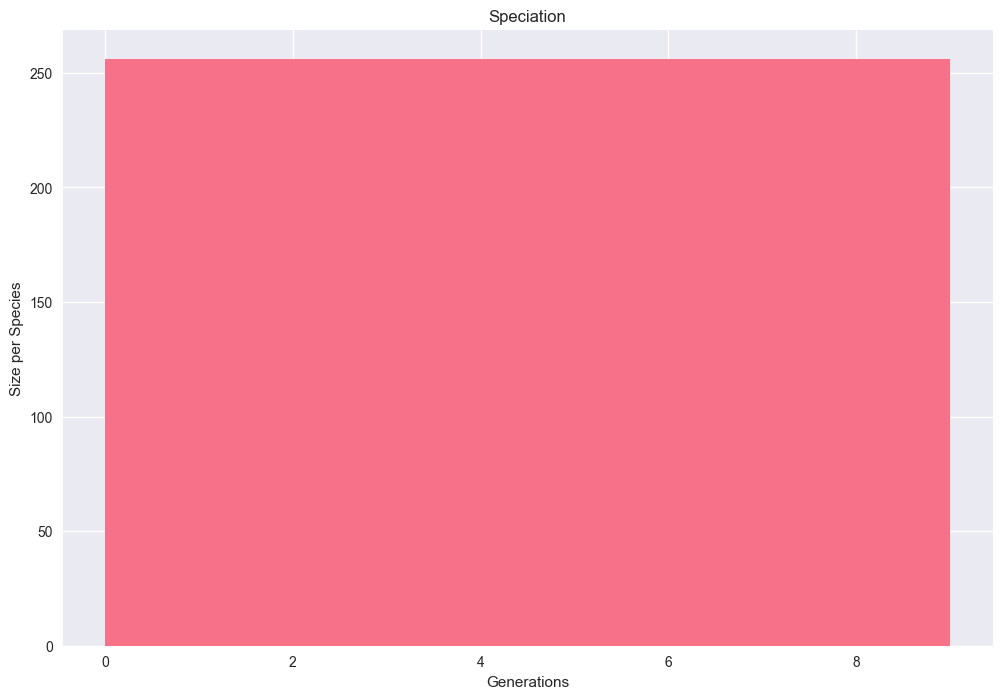

In [23]:
# Plot evolution statistics
try:
    from neat_trader.utils.visualize import plot_stats, plot_species
    
    print("📊 Creating evolution visualizations...")
    
    # Plot fitness statistics
    fig1 = plot_stats(trader.stats, ylog=False, view=True)
    #fig1.suptitle('NEAT Evolution Statistics', fontsize=16, fontweight='bold')
    plt.show()
    
    # Plot species statistics
    fig2 = plot_species(trader.stats, view=True)
    #fig2.suptitle('Species Evolution', fontsize=16, fontweight='bold')
    plt.show()
    
except Exception as e:
    print(f"❌ Visualization failed: {e}")
    print("💡 Try installing graphviz or check the visualization configuration")


In [31]:
# Visualize the winning network
if winner is not None:
    try:
        from neat_trader.utils.visualize import draw_net
        
        print("🕸️ Creating network topology visualization...")
        
        # Draw the network
        digraph = draw_net(
            config,
            winner,
            view=False,
            filename=f"{trader.checkpoint_path}/winner/winner_network",
            node_names=NODE_NAMES
        )
        
        if digraph:
            # Note: Digraph does not have a .show method
            print("✅ Network visualization saved to file")
        else:
            print("❌ Failed to create network visualization")
            
    except Exception as e:
        print(f"❌ Network visualization failed: {e}")
        print("💡 This might be due to graphviz configuration issues")


🕸️ Creating network topology visualization...
✅ Network visualization saved to file


<a id="optimization"></a>
## 7. Strategy Optimization

Let's explore different optimization approaches and compare fitness functions.


In [32]:
# Compare different fitness functions
def compare_fitness_functions(data_handler, generations=5, processes=2):
    """
    Compare different fitness functions on the same data.
    """
    results = {}
    
    for name, fitness_fn in fitness_functions.items():
        print(f"\n🧬 Testing {name} fitness function...")
        
        try:
            # Create new evaluator with different fitness function
            evaluator = Evaluator(
                data_handler=data_handler,
                fitness_fn=fitness_fn
            )
            
            # Create new trader
            trader = NeatTrader(config, evaluator)
            
            # Run evolution
            start_time = datetime.now()
            winner = trader.evolve(
                total_generation=generations,
                num_process=processes
            )
            end_time = datetime.now()
            
            duration = (end_time - start_time).total_seconds()
            
            results[name] = {
                'fitness': winner.fitness,
                'duration': duration,
                'connections': len([c for c in winner.connections.values() if c.enabled]),
                'nodes': len(winner.nodes)
            }
            
            print(f"✅ {name}: Fitness = {winner.fitness:.4f}, Duration = {duration:.2f}s")
            
        except Exception as e:
            print(f"❌ {name} failed: {e}")
            results[name] = {'fitness': 0, 'duration': 0, 'connections': 0, 'nodes': 0}
    
    return results

# Run comparison (uncomment to run - this will take several minutes)
# comparison_results = compare_fitness_functions(stock_data_handler)
print("💡 Uncomment the line above to run fitness function comparison")
print("⏱️ This will take several minutes to complete")


💡 Uncomment the line above to run fitness function comparison
⏱️ This will take several minutes to complete


In [33]:
# Demonstrate parameter optimization
def optimize_parameters():
    """
    Demonstrate how to optimize NEAT parameters.
    """
    print("⚙️ NEAT Parameter Optimization Guide:")
    print("\n📊 Key Parameters to Tune:")
    print("1. Population Size (pop_size):")
    print("   - Larger = more diversity, slower evolution")
    print("   - Smaller = faster evolution, less diversity")
    print("   - Recommended: 100-500 for trading strategies")
    
    print("\n2. Connection Mutation Rates:")
    print("   - connection_add_prob: Probability of adding new connections")
    print("   - connection_delete_prob: Probability of removing connections")
    print("   - Recommended: 0.1-0.3 for trading strategies")
    
    print("\n3. Node Mutation Rates:")
    print("   - node_add_prob: Probability of adding new nodes")
    print("   - node_delete_prob: Probability of removing nodes")
    print("   - Recommended: 0.05-0.15 for trading strategies")
    
    print("\n4. Compatibility Threshold:")
    print("   - compatibility_threshold: Species formation threshold")
    print("   - Lower = more species, higher diversity")
    print("   - Higher = fewer species, less diversity")
    print("   - Recommended: 3.0-5.0 for trading strategies")
    
    print("\n💡 Optimization Strategy:")
    print("1. Start with default parameters")
    print("2. Run multiple experiments with different settings")
    print("3. Track convergence speed and final performance")
    print("4. Use cross-validation on different market periods")
    print("5. Consider ensemble methods with multiple evolved strategies")

optimize_parameters()


⚙️ NEAT Parameter Optimization Guide:

📊 Key Parameters to Tune:
1. Population Size (pop_size):
   - Larger = more diversity, slower evolution
   - Smaller = faster evolution, less diversity
   - Recommended: 100-500 for trading strategies

2. Connection Mutation Rates:
   - connection_add_prob: Probability of adding new connections
   - connection_delete_prob: Probability of removing connections
   - Recommended: 0.1-0.3 for trading strategies

3. Node Mutation Rates:
   - node_add_prob: Probability of adding new nodes
   - node_delete_prob: Probability of removing nodes
   - Recommended: 0.05-0.15 for trading strategies

4. Compatibility Threshold:
   - compatibility_threshold: Species formation threshold
   - Lower = more species, higher diversity
   - Higher = fewer species, less diversity
   - Recommended: 3.0-5.0 for trading strategies

💡 Optimization Strategy:
1. Start with default parameters
2. Run multiple experiments with different settings
3. Track convergence speed and fina

## 8. Advanced Features and Best Practices

Let's explore advanced features and best practices for developing robust trading strategies.


In [34]:
# Advanced strategy development tips
def advanced_strategy_tips():
    """
    Advanced tips for developing robust trading strategies.
    """
    print("🚀 Advanced NEAT Trading Strategy Development Tips:")
    
    print("\n📊 Data Preparation:")
    print("• Use multiple market conditions (bull, bear, sideways)")
    print("• Include different asset classes and timeframes")
    print("• Ensure sufficient historical data (at least 2-3 years)")
    print("• Normalize features to prevent bias toward high-magnitude indicators")
    
    print("\n🧬 Evolution Strategy:")
    print("• Run multiple independent evolutions and ensemble the best performers")
    print("• Use progressive training: start simple, increase complexity")
    print("• Implement early stopping to prevent overfitting")
    print("• Track both in-sample and out-of-sample performance")
    
    print("\n🎯 Fitness Function Design:")
    print("• Balance multiple objectives: returns, risk, transaction costs")
    print("• Include drawdown penalties to control risk")
    print("• Consider market regime awareness")
    print("• Penalize excessive trading to reduce costs")
    
    print("\n⚖️ Risk Management:")
    print("• Implement position sizing based on volatility")
    print("• Set maximum drawdown limits")
    print("• Use stop-loss mechanisms")
    print("• Monitor correlation with market benchmarks")
    
    print("\n🔄 Continuous Improvement:")
    print("• Regularly retrain on new data")
    print("• Monitor strategy decay and performance degradation")
    print("• Implement adaptive mechanisms for changing markets")
    print("• Use walk-forward analysis for robust validation")

advanced_strategy_tips()


🚀 Advanced NEAT Trading Strategy Development Tips:

📊 Data Preparation:
• Use multiple market conditions (bull, bear, sideways)
• Include different asset classes and timeframes
• Ensure sufficient historical data (at least 2-3 years)
• Normalize features to prevent bias toward high-magnitude indicators

🧬 Evolution Strategy:
• Run multiple independent evolutions and ensemble the best performers
• Use progressive training: start simple, increase complexity
• Implement early stopping to prevent overfitting
• Track both in-sample and out-of-sample performance

🎯 Fitness Function Design:
• Balance multiple objectives: returns, risk, transaction costs
• Include drawdown penalties to control risk
• Consider market regime awareness
• Penalize excessive trading to reduce costs

⚖️ Risk Management:
• Implement position sizing based on volatility
• Set maximum drawdown limits
• Use stop-loss mechanisms
• Monitor correlation with market benchmarks

🔄 Continuous Improvement:
• Regularly retrain on

In [35]:
# Demonstrate ensemble strategy approach
def create_ensemble_strategy():
    """
    Demonstrate how to create an ensemble of multiple evolved strategies.
    """
    print("🎭 Ensemble Strategy Development:")
    
    print("\n📋 Steps to create an ensemble:")
    print("1. Evolve multiple independent strategies with different:")
    print("   • Fitness functions (multi-objective, risk-adjusted, etc.)")
    print("   • Market periods (different years, market conditions)")
    print("   • NEAT parameters (population size, mutation rates)")
    
    print("\n2. Strategy Selection:")
    print("   • Select top performers based on multiple criteria")
    print("   • Ensure diversity in trading patterns")
    print("   • Avoid highly correlated strategies")
    
    print("\n3. Ensemble Methods:")
    print("   • Equal weighting: Simple average of signals")
    print("   • Performance weighting: Weight by historical performance")
    print("   • Voting: Majority vote on buy/sell decisions")
    print("   • Dynamic weighting: Adjust weights based on recent performance")
    
    print("\n4. Validation:")
    print("   • Test ensemble on out-of-sample data")
    print("   • Compare with individual strategies")
    print("   • Monitor for overfitting and performance degradation")
    
    print("\n💡 Example ensemble configuration:")
    print("• 3 strategies optimized for different market regimes")
    print("• 2 strategies with different risk preferences")
    print("• 1 strategy focused on high-frequency signals")
    print("• Dynamic rebalancing every month")

create_ensemble_strategy()


🎭 Ensemble Strategy Development:

📋 Steps to create an ensemble:
1. Evolve multiple independent strategies with different:
   • Fitness functions (multi-objective, risk-adjusted, etc.)
   • Market periods (different years, market conditions)
   • NEAT parameters (population size, mutation rates)

2. Strategy Selection:
   • Select top performers based on multiple criteria
   • Ensure diversity in trading patterns
   • Avoid highly correlated strategies

3. Ensemble Methods:
   • Equal weighting: Simple average of signals
   • Performance weighting: Weight by historical performance
   • Voting: Majority vote on buy/sell decisions
   • Dynamic weighting: Adjust weights based on recent performance

4. Validation:
   • Test ensemble on out-of-sample data
   • Compare with individual strategies
   • Monitor for overfitting and performance degradation

💡 Example ensemble configuration:
• 3 strategies optimized for different market regimes
• 2 strategies with different risk preferences
• 1 st

## 9. Performance Monitoring and Maintenance

Finally, let's discuss how to monitor and maintain your evolved trading strategies.


In [36]:
# Performance monitoring framework
def performance_monitoring_framework():
    """
    Framework for monitoring and maintaining trading strategies.
    """
    print("📊 Performance Monitoring Framework:")
    
    print("\n📈 Key Performance Metrics:")
    print("• Sharpe Ratio: Risk-adjusted returns")
    print("• Maximum Drawdown: Largest peak-to-trough decline")
    print("• Win Rate: Percentage of profitable trades")
    print("• Profit Factor: Gross profit / Gross loss")
    print("• Calmar Ratio: Annual return / Maximum drawdown")
    print("• Sortino Ratio: Downside deviation adjusted returns")
    
    print("\n🚨 Warning Signals:")
    print("• Declining Sharpe ratio over time")
    print("• Increasing maximum drawdown")
    print("• Decreasing win rate")
    print("• High correlation with market crashes")
    print("• Excessive trading frequency")
    
    print("\n🔄 Maintenance Schedule:")
    print("• Daily: Monitor position sizes and risk metrics")
    print("• Weekly: Review performance vs. benchmarks")
    print("• Monthly: Rebalance ensemble weights")
    print("• Quarterly: Retrain strategies on new data")
    print("• Annually: Full strategy review and optimization")
    
    print("\n🛠️ Adaptive Mechanisms:")
    print("• Dynamic position sizing based on volatility")
    print("• Market regime detection and strategy switching")
    print("• Automatic retraining triggers")
    print("• Circuit breakers for extreme market conditions")

performance_monitoring_framework()


📊 Performance Monitoring Framework:

📈 Key Performance Metrics:
• Sharpe Ratio: Risk-adjusted returns
• Maximum Drawdown: Largest peak-to-trough decline
• Win Rate: Percentage of profitable trades
• Profit Factor: Gross profit / Gross loss
• Calmar Ratio: Annual return / Maximum drawdown
• Sortino Ratio: Downside deviation adjusted returns

🚨 Warning Signals:
• Declining Sharpe ratio over time
• Increasing maximum drawdown
• Decreasing win rate
• High correlation with market crashes
• Excessive trading frequency

🔄 Maintenance Schedule:
• Daily: Monitor position sizes and risk metrics
• Weekly: Review performance vs. benchmarks
• Monthly: Rebalance ensemble weights
• Quarterly: Retrain strategies on new data
• Annually: Full strategy review and optimization

🛠️ Adaptive Mechanisms:
• Dynamic position sizing based on volatility
• Market regime detection and strategy switching
• Automatic retraining triggers
• Circuit breakers for extreme market conditions


## Conclusion

This notebook has demonstrated how to use the NEAT Trader package to develop sophisticated automated trading strategies. Key takeaways:

1. **NEAT Algorithm**: Evolves neural networks that can learn complex trading patterns
2. **Multi-Objective Optimization**: Balances returns, risk, and transaction costs
3. **Technical Indicators**: Uses multiple indicators for robust decision-making
4. **Flexible Framework**: Supports different fitness functions and market data
5. **Comprehensive Analysis**: Provides detailed performance metrics and visualizations

### Next Steps:

1. **Extend Training**: Run longer evolutions (100+ generations) for better performance
2. **Multiple Markets**: Test on different asset classes and timeframes
3. **Ensemble Methods**: Combine multiple evolved strategies for robustness
4. **Live Trading**: Implement paper trading before real money deployment
5. **Continuous Learning**: Regularly retrain and update strategies

### Important Notes:

- Always backtest thoroughly before live deployment
- Monitor performance continuously and be ready to adapt
- Consider transaction costs and market impact in your strategies
- Diversify across multiple strategies and timeframes
- Keep detailed logs for regulatory compliance

Happy trading! 🚀📈
